# Ejercicio 1: Breast cancer

In cancer detection, we want to minimize incorrect negative predictions (i.e. the sick patient is classified as negative) because this diagnosis could lead to serious health problems. Therefore, the most important metric in the application of cancer detection is the recall which objective is to limit the number of false negatives.

## Load data

In [1]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [2]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

**Target**  
'0' => malignant/sick  
'1' => benign/safe

## Preprocessing

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['target'] = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(df_cancer.drop('target', axis=1), df_cancer['target'], test_size=0.3, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Training

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'SVC (poly)',
        'model': SVC(random_state=42, kernel='poly'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },

    {
        'name_clf' : 'SVC (linear)',
        'model': SVC(random_state=42, kernel='linear'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },

    {
        'name_clf' : 'SVC (rbf)',
        'model': SVC(random_state=42, kernel='rbf'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },

    {
        'name_clf' : 'SVC (sigmoid)',
        'model': SVC(random_state=42, kernel='sigmoid'),
        'scalers' : {
            'scaler': [None, StandardScaler(), MinMaxScaler()],
        },
        'grid' : {
            'model__C': [10**k for k in range(-4, 5)],
            'model__gamma': [10**k for k in range(-4, 5)],
        }
    },


]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
from utils import model_evaluation_clf

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "Accuracy", "Precision", "Recall", "f1-score", "AUC"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    print(f'Training {model_name}...')

    model = dict_clf['model']

    steps = [
        ('scaler', None),
        ('model', model),
    ]

    pipeline = Pipeline(steps)

    param_grid = {
        **dict_clf['scalers'],
        **dict_clf['grid']
    }

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

    start_time = time()
    clf.fit(X_train, y_train)
    end_time = time()
    
    print(f"Best params {model_name}: \n{clf.best_params_}")

    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf

    results.loc[nb_res] = [model_name, round(end_time - start_time, 1), eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc']]
    nb_res += 1

    print(f"CPU Time: {round(end_time - start_time, 1)}s")
    print()

Training SVC (poly)...


## Results

In [ ]:
print(results.to_string(index=False))

        Model  CPU time  Accuracy  Precision  Recall  f1-score   AUC
 SVC (linear)     103.6     0.977      0.981   0.981     0.981 0.975
    SVC (rbf)       1.1     0.988      0.982   1.000     0.991 0.984
SVC (sigmoid)       0.8     0.982      0.982   0.991     0.986 0.979


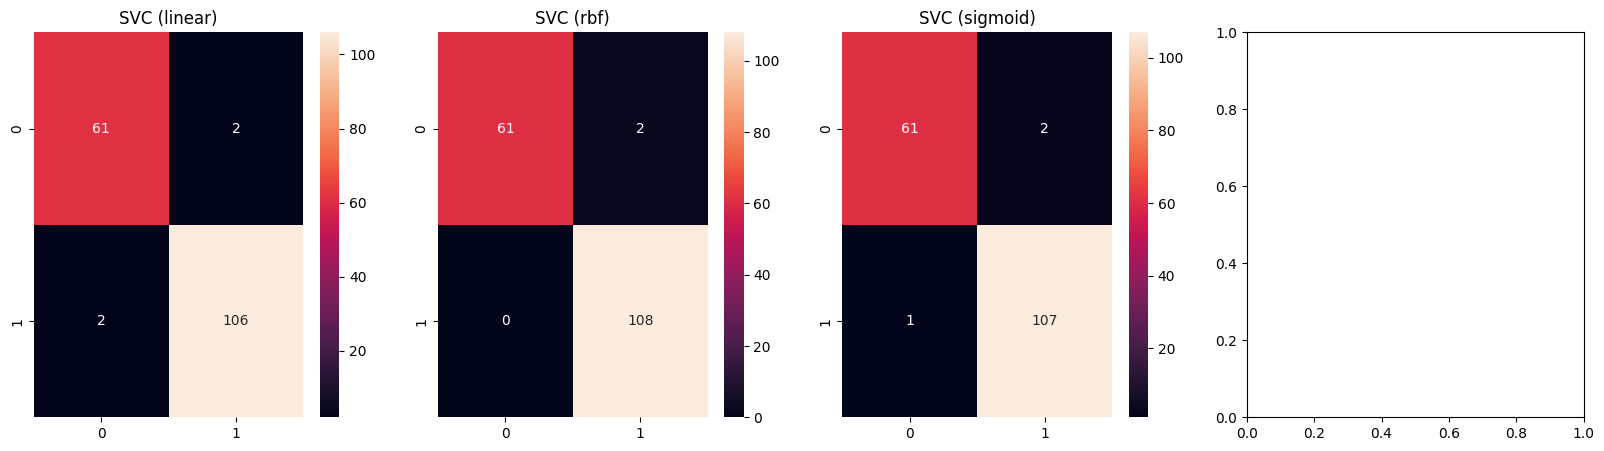

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(model_name)

plt.show()

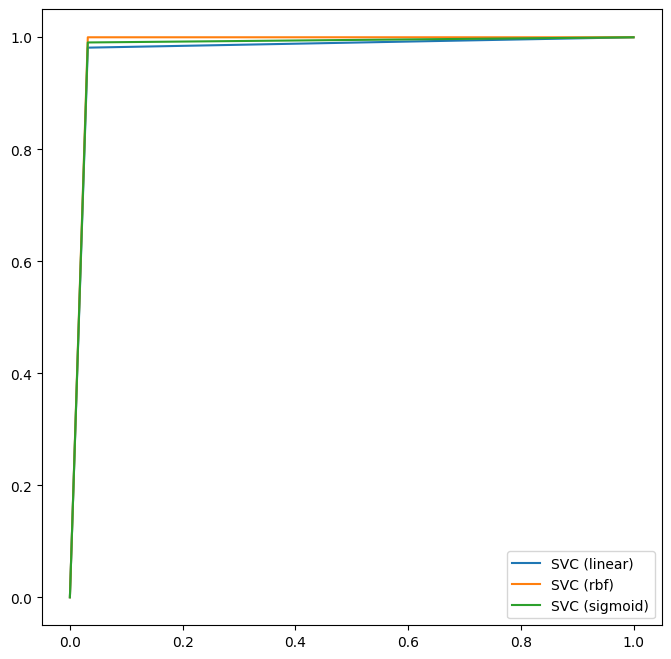

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(5, 5))

for model_name in models.keys():
    model = models[model_name]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)

plt.legend()
plt.show()
